<h1> Modelling and evaluation </h1>
<h2> 1. Importing libraries and downloading datasets </h2>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score as ACC
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from keras import layers
from keras.layers import RNN, Dense, Dropout, BatchNormalization
from keras import Sequential, layers, Input, callbacks

from xgboost import XGBClassifier 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model

from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [102]:
# Importing all the datasets
train_A = pd.read_csv('data/train_A.csv')
val_A = pd.read_csv('data/val_A.csv')
test_A = pd.read_csv('data/test_A.csv')


train_B = pd.read_csv('data/train_B.csv')
val_B = pd.read_csv('data/val_B.csv')
test_B = pd.read_csv('data/test_B.csv')


train_C = pd.read_csv('data/train_C.csv')
val_C = pd.read_csv('data/val_C.csv')
test_C = pd.read_csv('data/test_C.csv')


train_D = pd.read_csv('data/train_D.csv')
val_D= pd.read_csv('data/val_D.csv')
test_D = pd.read_csv('data/test_D.csv')

In [30]:
# B1 = pd.read_csv('data/train_df.csv')
# B2= pd.read_csv('data/val_df.csv')
# B3 = pd.read_csv('data/test_df.csv')

# B1 = common_label_removal(B1).reset_index(drop=True)
# B2 = common_label_removal(B2).reset_index(drop=True)
# B3 = common_label_removal(B3).reset_index(drop=True)

<h2> 2. Data preprocessing </h2>

In [103]:
datasets = [train_A, val_A, test_A, 
            train_B, val_B, test_B, 
            train_C, val_C, test_C,
            train_D, val_D, test_D]


In [104]:
# train_A.head(2)

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,fear,anger,positive,negative,disgust,surprise,joy,anticipation,sadness,avg_tf-idf
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.0,...,0,0,0,0,0,0,0,0,0,0.0


In [106]:
# val_A.head(2)

In [91]:
# train_A

In [53]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "ARAGORN"]

# Creating a common label for the characters not of interest
def common_label_removal(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data


def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    # print(names)
    # print(np.unique(encoded_data))
    return encoded_data, names

def preprocessing(data):
    data = common_label_removal(data)
    x_data, y_data = x_y_split(data)
    y_data = char_2_num(y_data)
    return x_data, y_data


In [107]:
A_tra_X = common_label_removal(train_A).reset_index(drop=True).iloc[:,2:]
A_val_X =common_label_removal(val_A).reset_index(drop=True).iloc[:,2:]
A_test_X=common_label_removal(test_A).reset_index(drop=True).iloc[:,2:]

B_tra_X = train_B
B_val_X = val_B
B_test_X= test_B

C_tra_X = common_label_removal(train_C).reset_index(drop=True).iloc[:,2:]
C_val_X = common_label_removal(val_C).reset_index(drop=True).iloc[:,2:]
C_test_X= common_label_removal(test_C).reset_index(drop=True).iloc[:,2:]

D_tra_X = common_label_removal(train_D).reset_index(drop=True).iloc[:,2:]
D_val_X = common_label_removal(val_D).reset_index(drop=True).iloc[:,2:]
D_test_X= common_label_removal(test_D).reset_index(drop=True).iloc[:,2:]

tra_y = preprocessing(train_C)[1][0]
val_y = preprocessing(val_C)[1][0]
test_y = preprocessing(test_C)[1][0]

tra_y_eye = np.eye(10)[tra_y]
val_y_eye = np.eye(10)[val_y]
test_y_eye = np.eye(10)[test_y]

<h2> 2. Benchmarks </h2>
<h3> 2.1 Naive Benchmark, Monte Carlo Method </h3>
<p> Using 1000 simulations with random guesses on target labels. </p>

In [78]:
def naive_benchmark_MonC(y):
    accuracy_list = []
    for i in range(0,1000,1):
        naive_rand_pred = np.random.randint(0,12,size=(len(y)))
        accuracy_sel = ACC(naive_rand_pred, y)
        accuracy_list.append(accuracy_sel)
    return np.mean(accuracy_list)

In [80]:
naive_benchmark_MonC(test_y)

0.08344871794871796

<h3> 2.2 Naive Benchmark, Majority Class Method </h3>
<p> Using Frodo, which equals label 2, as guess </p>

In [108]:
def naive_benchmark_MajC(y):                
    pred_MCNB =np.repeat(2,len(y))
    return ACC(pred_MCNB, y)

In [109]:
naive_benchmark_MajC(test_y)

0.1752136752136752

<h2> 3. Modelling  </h2>
<!-- <h3> 3.1 ANN on dataset A</h3> -->
<!-- <p> Dataset A contains various numerical retrieved from the characters. </p>
<p> The feedforward neural network has a relative simple architecture. -->

<h3> 3.1 XGBC on dataset D

In [83]:
p_g = {
    'objective':['multi:softprob'],
    'alpha': hp.uniform('alpha',0,1),
    'gamma': hp.uniform('gamma',0,9),
    'reg_lambda':hp.quniform('reg_lamda',0,3,1),
    'max_depth':hp.quniform('max_depth',6,12,1),
    'learning_rate': hp.uniform('learning_rate',0.001,0.05),
    'n_estimators': hp.quniform('n_estimators', 5,500,1),
    'min_child_weight': hp.quniform('min_child_weight',0,5,1),
    'seed':42
    }

In [110]:
def bayopt_xgb(p_g):
    internal_model = XGBClassifier(
                     objective='multi:softmax',
                     alpha=p_g['alpha'],
                     gamma=p_g['gamma'],
                     reg_lambda= p_g['reg_lambda'],
                     max_depth = int(p_g['max_depth']),
                     n_estimator = (p_g['n_estimators']),
                     learning_rate=p_g['learning_rate'],
                     min_child_weight=p_g['min_child_weight'],
                     seed =p_g['seed'],
                     )

    internal_model.fit(D_tra_X, tra_y,
                     eval_set = [(D_val_X, val_y)],
                     eval_metric = 'mlogloss',
                     early_stopping_rounds=25,verbose=False)
    
    # pred_valid = internal_model.predict(A2)
    # score = ACC(pred_valid, A_tra_y)

    score =np.mean(cross_val_score(internal_model, D_tra_X, tra_y, scoring='accuracy', cv=3))
    print('Score:', score)
    return {'loss':-score, 'status':STATUS_OK}

def tune():
    trials = Trials()
    best_tune = fmin(fn=bayopt_xgb, 
                    space=p_g,
                    algo= tpe.suggest,
                    max_evals=10,
                    trials=trials)
    return best_tune


ntune = tune()
ntune['n_estimators'] =  int(ntune['n_estimators'])
ntune['max_depth'] =  int(ntune['max_depth'])
xmodel = XGBClassifier(**ntune)

Score:                                                
0.20228151955490548                                   
Score:                                                                            
0.21273221877434964                                                               
Score:                                                                            
0.2249440670011255                                                                
Score:                                                                            
0.20837377368893506                                                              
Score:                                                                           
0.2153431848317909                                                               
Score:                                                                           
0.2362628099098237                                                               
Score:                                                           

In [112]:
xmodel.fit(D_tra_X, tra_y)

XGBClassifier(alpha=0.8959623732375052, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.91103085281158, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003074548412767403,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=430, n_jobs=None,
              num_parallel_tree=None, ...)

In [117]:
print('Accuracy train: ',ACC(xmodel.predict(D_tra_X),tra_y))
print('Accuracy validation: ',ACC(xmodel.predict(D_val_X),val_y))
print('Accuracy test: ',ACC(xmodel.predict(D_test_X),test_y))

Accuracy train:  0.2972972972972973
Accuracy validation:  0.2283464566929134
Accuracy test:  0.25213675213675213


<h3> 3.2 RNN on dataset B </h3>
<p> Dataset B contains embeddings(?). This, I need to read myself up on.</p>

In [122]:
emb_model = Sequential([
    layers.Embedding(input_dim=2500, output_dim=15, input_length=B_tra_X.shape[1]),
    # layers.Flatten(),
    layers.LSTM(8,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0,3),
    layers.Dense(32, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # layers.Dense(64, activation='gelu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
emb_model.compile(optimizer=optimizer, 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=35, # how many epochs to wait before stopping
    restore_best_weights=True,
)

emb_model.fit(B_tra_X,tra_y_eye, epochs=100, batch_size=60, 
        validation_data=(B_val_X, val_y_eye),
        callbacks=early_stopping,)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.1364 - loss: 2.2878 - val_accuracy: 0.1299 - val_loss: 2.2324
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.1544 - loss: 2.2719 - val_accuracy: 0.1299 - val_loss: 2.2355
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.1546 - loss: 2.2584 - val_accuracy: 0.1299 - val_loss: 2.2386
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 970ms/step - accuracy: 0.1456 - loss: 2.2652 - val_accuracy: 0.1299 - val_loss: 2.2610
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 931ms/step - accuracy: 0.1397 - loss: 2.2682 - val_accuracy: 0.1260 - val_loss: 2.2757
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 717ms/step - accuracy: 0.1287 - loss: 2.2660 - val_accuracy: 0.1260 - val_loss: 2.3040
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 711ms/step - accuracy: 0.1324 - loss: 2.2539 - val_accuracy: 0.1260 - val_loss: 2.2595
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 704ms/step - accuracy: 0.1560 - loss: 2.2665 - 

In [ ]:
emb_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 86, 15)         │        37,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,788 (487.46 KB)

 Trainable params: 41,526 (162.21 KB)

 Non-trainable params: 208 (832.00 B)

 Optimizer params: 83,054 (324.43 KB)

In [ ]:
# Train accuracy
emb_model.evaluate(B_tra_X, tra_y_eye)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1151 - loss: 2.2650


[2.2605466842651367, 0.120313860476017]

In [ ]:
# Validation accuracy
emb_model.evaluate(B_val_X, val_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1400 - loss: 2.2206 


[2.228026866912842, 0.16929133236408234]

In [ ]:
# Test accuracy
emb_model.evaluate(B_test_X, test_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1731 - loss: 2.1997


[2.2167019844055176, 0.14102564752101898]

<p> sources </p>
<ul>
<li>https://keras.io/api/models/model/</li>
<li>https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456</li>
<li>https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer</li>
<li>https://medium.com/@iqra.bismi/understanding-keras-embedding-for-natural-language-processing-9f65a281b1a7</li>

</ul>

<h3> 3.3 RFC on dataset C </h3>
<p>  Dataset C contains a counter on how many times a specific word have been mentioned in a quote. </p>

In [ ]:
param_grid = {
    'n_estimators': [30,35,45,55,65,75,85,95],
    'max_depth': [6,9,12,15,18,21,24,27,30],
}

acc_list = []
for n in range(len(param_grid['n_estimators'])):
    nE = param_grid['n_estimators'][n]
    for d in range(len(param_grid['max_depth'])):
        mD = param_grid['max_depth'][d]
        
        model = RandomForestClassifier(n_estimators=nE, max_depth=mD, random_state=42) 
        model.fit(C_tra_X,tra_y)
        X1 = model.predict(C_tra_X)
        x2 = model.predict(C_val_X)
        acc_list.append(ACC(x2, val_y))


In [ ]:
a = pd.Series(acc_list)
np.where(a==max(a))

(array([59], dtype=int64),)

In [ ]:
59%8

In [ ]:
59//8

In [ ]:
#ne 85
#md 24
rfc_model = RandomForestClassifier(n_estimators=55, max_depth=15,random_state=42)
rfc_model.fit(C_tra_X,C_tra_y)
predCtrain= rfc_model.predict(C_tra_X)
predCval= rfc_model.predict(C_val_X)
predCtest= rfc_model.predict(C_tar_X)

In [ ]:
# Train accuracy 
ACC(predCtrain, C_tra_y)

0.5483870967741935

In [ ]:
# Train accuracy 
ACC(predCval, C_val_y)

0.2952755905511811

In [ ]:
# Train accuracy 
ACC(predCtest, C_tar_y)

0.3247863247863248

<h2> 4. Ensemble model </h2>
<p> The RFC contains absolutely best results therefore, they will have prioritized votes if there are ties. </p>

In [ ]:
# XGBC
P1 = xmodel.predict(A3)

# LSTM
pp2 = emb_model.predict(B3_padseq)
P2 = pp2.argmax(axis=1)

# RFC
P3 = rfc_model.predict(C_tar_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [ ]:
final_preds = []
for i in range(len(P1)):
    preds =  [P1[i],P2[i],P3[i]]
    if preds[0]==preds[1]:
        ans = preds[0]
    elif preds[0]==preds[2]:
        ans= preds[0]
    elif preds[1]==preds[2]:
        ans=preds[1]
    else:
        ans = preds[2]
    final_preds.append(ans)
ACC(final_preds, A_tar_y)

0.33760683760683763

In [ ]:
def evaluate_model(pred, target):
    eval_methods = [ f1_score, precision_score, recall_score]

    print(classification_report(pred, target))
    print("Accuracy ", round(ACC(pred, target), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(pred, target, average='weighted'), 4)) 
    # return pred  

In [ ]:

def conf_matrix(y, pred):
    cm = confusion_matrix(pred,y)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=imp_char, yticklabels=imp_char)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

<h2> results: </h2>
<h3> XGBC

In [ ]:
evaluate_model(P1, D_tar_y)

              precision    recall  f1-score   support

           0       0.75      0.15      0.25       139
           1       0.00      0.00      0.00         3
           2       0.17      0.64      0.27        11
           3       0.27      0.43      0.33        21
           4       0.00      0.00      0.00         0
           5       0.61      0.52      0.56        21
           6       0.00      0.00      0.00         2
           7       0.17      0.24      0.20        17
           8       0.32      0.60      0.42        20
           9       0.00      0.00      0.00         0

    accuracy                           0.27       234
   macro avg       0.23      0.26      0.20       234
weighted avg       0.57      0.27      0.29       234

Accuracy  0.2735
f1_score 0.2928
precision_score 0.5727
recall_score 0.2735


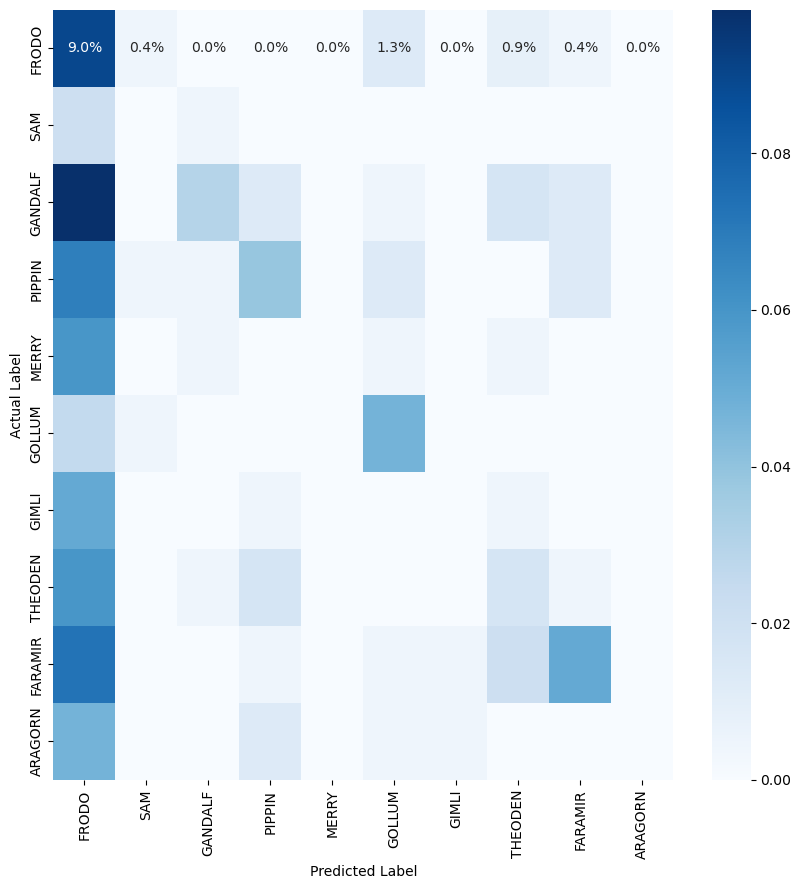

In [ ]:
conf_matrix(P1, D_tar_y)

<h3> RNN

In [ ]:
evaluate_model(P2, D_tar_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.14      0.25       234
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.14       234
   macro avg       0.10      0.01      0.02       234
weighted avg       1.00      0.14      0.25       234

Accuracy  0.141
f1_score 0.2472
precision_score 1.0
recall_score 0.141


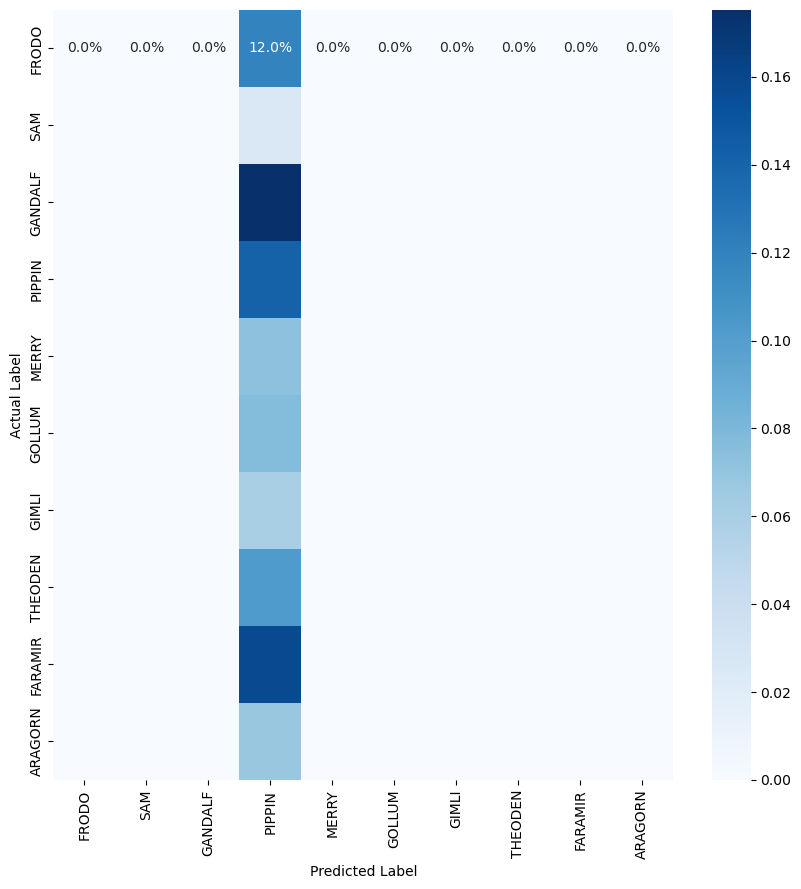

In [ ]:
conf_matrix(P2, D_tar_y)

<h3> RFC

In [ ]:
evaluate_model(P3, D_tar_y)

              precision    recall  f1-score   support

           0       0.07      0.33      0.12         6
           1       0.00      0.00      0.00         0
           2       0.80      0.22      0.35       150
           3       0.27      0.69      0.39        13
           4       0.00      0.00      0.00         0
           5       0.56      0.45      0.50        22
           6       0.00      0.00      0.00         2
           7       0.17      0.36      0.23        11
           8       0.43      0.57      0.49        28
           9       0.12      1.00      0.22         2

    accuracy                           0.32       234
   macro avg       0.24      0.36      0.23       234
weighted avg       0.65      0.32      0.36       234

Accuracy  0.3248
f1_score 0.3648
precision_score 0.6458
recall_score 0.3248


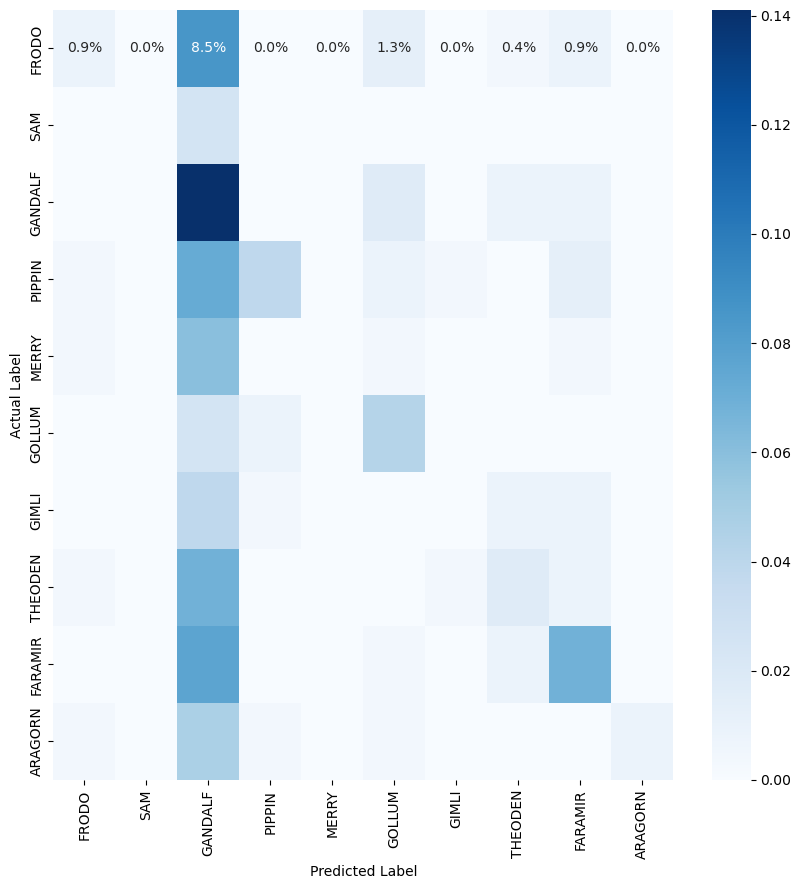

In [ ]:
conf_matrix(P3, D_tar_y)

<h3> Ensemble


In [ ]:
evaluate_model(final_preds, D_tar_y)

              precision    recall  f1-score   support

           0       0.07      0.50      0.12         4
           1       0.00      0.00      0.00         0
           2       0.76      0.22      0.34       143
           3       0.48      0.52      0.50        31
           4       0.00      0.00      0.00         0
           5       0.56      0.48      0.51        21
           6       0.00      0.00      0.00         1
           7       0.17      0.36      0.23        11
           8       0.41      0.68      0.51        22
           9       0.06      1.00      0.12         1

    accuracy                           0.34       234
   macro avg       0.25      0.38      0.23       234
weighted avg       0.62      0.34      0.38       234

Accuracy  0.3376
f1_score 0.3794
precision_score 0.6236
recall_score 0.3376


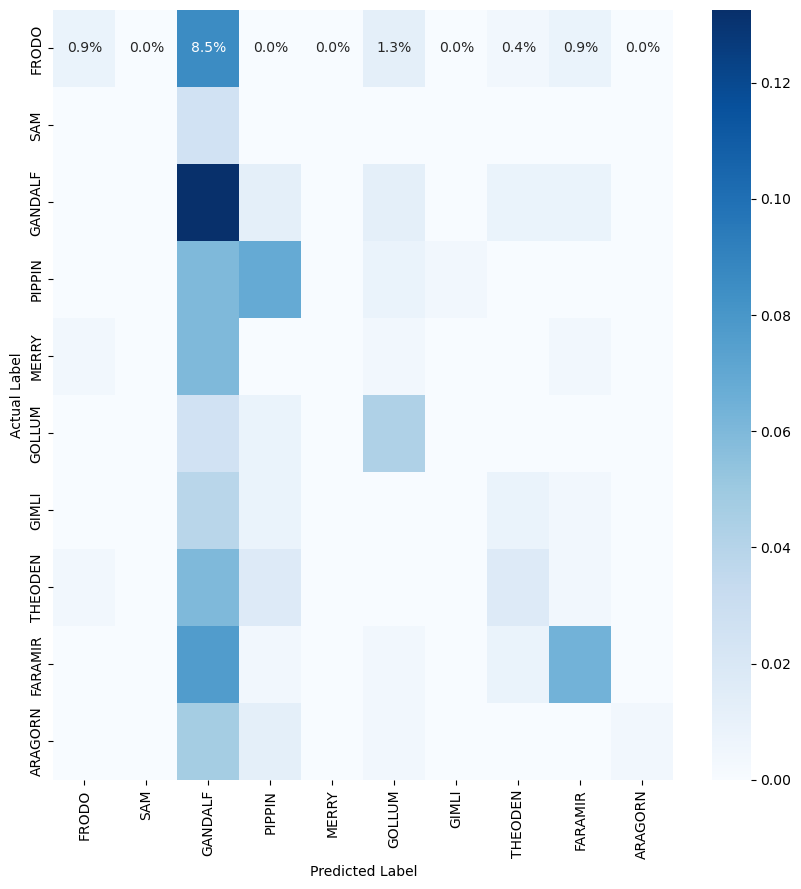

In [ ]:
conf_matrix(final_preds, D_tar_y)

<h1> 5. Conclusion: </h1>
<p> We have used three different datasets trained on three different models. The best individual model is the random forest classifier, which is trained on dummy coded BoW. </p>
<br>
<p> Furthermore, all the models have been put together in an ensemble model, where the majority class wins. The accuracy of the ensemble model is equal to the accuracy retrieved from the rfc model. This might indicate that there are no documents where the two other models agrees upon another label than the rfc model. In other words; the other models are do not give any type of additional explanatory power other what than the rfc model gives.</p>
<br>
<p> The upside of the modelling phase is that we have been able to create a model that is better than random guessing by 300% and a model that better than guessing Frodo all the time by approximately 100%. </p>
<br>
<h1> Biological hazard have left the building at 01:55.  </h1>